In [70]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import time
from skopt import gp_minimize
from skopt.space import Real, Integer
import abc
import matplotlib.patches as patches

In [71]:
# Leer archivo txt de dos columnas: tiempo y porcentaje de conversión
archivo1 = "/Users/gtorres/Desktop/proyecto/00_TrabajoGradoGerman/Malaria/Codes/Datos Experimentales/beta-hematina_C1.txt"
archivo2 = "/Users/gtorres/Desktop/proyecto/00_TrabajoGradoGerman/Malaria/Codes/Datos Experimentales/beta-hematina_C2.txt"
archivo3 = "/Users/gtorres/Desktop/proyecto/00_TrabajoGradoGerman/Malaria/Codes/Datos Experimentales/beta-hematina.txt"

data_txt1 = pd.read_csv(archivo1, sep="\s+", header=None, names=["Tiempo", "Porcentaje"])
data_txt2 = pd.read_csv(archivo2, sep="\s+", header=None, names=["Tiempo", "Porcentaje"])
data_txt3 = pd.read_csv(archivo3, sep="\s+", header=None, names=["Tiempo", "Porcentaje", "Error"])

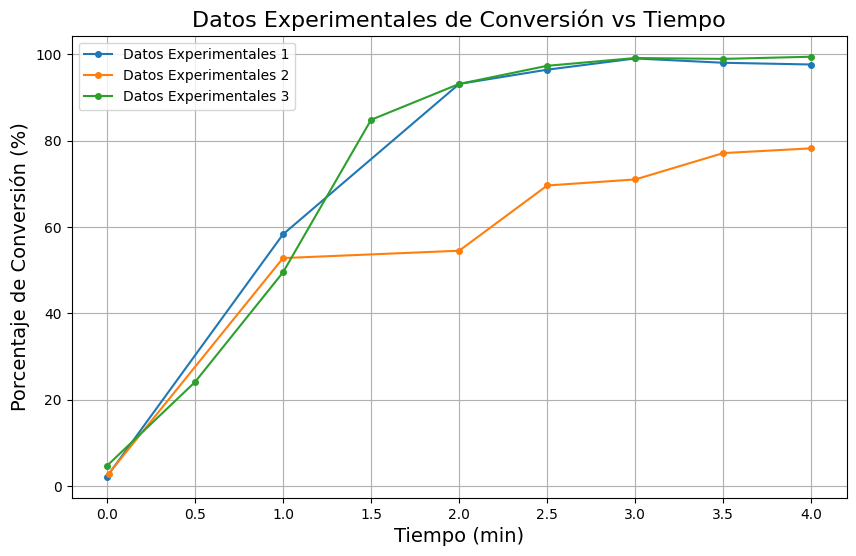

In [72]:
Experiments = [data_txt1, data_txt2, data_txt3]

plt.figure(figsize=(10, 6))
for i, exp in enumerate(Experiments, start=1):
    plt.plot(exp["Tiempo"], exp["Porcentaje"], '-o', label=f'Datos Experimentales {i}', markersize=4)
plt.xlabel('Tiempo (min)', fontsize=14)
plt.ylabel('Porcentaje de Conversión (%)', fontsize=14)
plt.title('Datos Experimentales de Conversión vs Tiempo', fontsize=16)
plt.legend()
plt.grid()
plt.show()

In [ ]:
import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

# =============================
# Lattice model (SOS approximation)
# =============================
class LatticeSOS:
    """
    Simple solid-on-solid (SOS) lattice with integer column heights.
    - heights[i, j] ∈ {0,1,2,...}
    - 4-neighbor (von Neumann) connectivity with periodic BCs.
    """
    def __init__(self, size: int, seed: Optional[int] = None):
        self.size = size
        self.rng = np.random.default_rng(seed)
        self.heights = np.zeros((size, size), dtype=np.int32)

    def initialize(self, init_mode: str = "flat", max_roughness: int = 1):
        if init_mode == "flat":
            self.heights.fill(0)
        elif init_mode == "random_surface":
            self.heights = self.rng.integers(0, max(1, max_roughness+1),
                                             size=self.heights.shape, dtype=np.int32)
        else:
            raise ValueError("Unknown init_mode")

    def wrap(self, idx: int) -> int:
        n = self.size
        return (idx + n) % n

    def neighbors4(self, site: Tuple[int,int]) -> List[Tuple[int,int]]:
        i, j = site
        return [
            (self.wrap(i-1), j), (self.wrap(i+1), j),
            (i, self.wrap(j-1)), (i, self.wrap(j+1))
        ]

    def get_height(self, site: Tuple[int,int]) -> int:
        return int(self.heights[site])

    def inc_height(self, site: Tuple[int,int], dh: int = 1):
        self.heights[site] += int(dh)

    def dec_height(self, site: Tuple[int,int], dh: int = 1):
        h = int(self.heights[site])
        if h >= dh:
            self.heights[site] = h - dh

    # ---- Site classification helpers ----
    def lateral_neighbors_at_level(self, site: Tuple[int,int], level: int) -> int:
        cnt = 0
        for n in self.neighbors4(site):
            if self.get_height(n) >= level:
                cnt += 1
        return cnt

    def adsorption_bonds(self, site: Tuple[int,int]) -> int:
        h = self.get_height(site)
        return self.lateral_neighbors_at_level(site, h+1)

    def desorption_bonds(self, site: Tuple[int,int]) -> int:
        h = self.get_height(site)
        if h == 0:
            return 0
        return self.lateral_neighbors_at_level(site, h)

    def migration_targets(self, site: Tuple[int,int]) -> List[Tuple[int,int]]:
        h = self.get_height(site)
        if h == 0:
            return []
        targets = []
        for n in self.neighbors4(site):
            if self.get_height(n) <= h:
                targets.append(n)
        return targets

    def get_sites(self) -> List[Tuple[int,int]]:
        idxs = np.argwhere(np.ones_like(self.heights, dtype=bool))
        return [tuple(x) for x in idxs]

def safe_exp(x, clip=700.0):
    """exp(x) con protección contra overflow."""
    try:
        if x > clip:   # límite máximo para evitar overflow
            return np.exp(clip)
        elif x < -clip:
            return np.exp(-clip)
        else:
            return np.exp(x)
    except FloatingPointError:
        return np.exp(clip)  # fallback seguro


# =============================
# Parameters
# =============================
@dataclass
class KMCParams:
    T: float
    K0_plus: float        # prefactor ads/des/mig
    K_inc_plus: float     # prefactor de incorporación
    E_pb_over_kT: float
    phi_over_kT: float
    delta: float
    # supersaturación dinámica
    V: float
    C_eq: float
    S_floor: float = -5.0
    S_ceil: float = 8.0


# =============================
# Adaptive BKL kMC with incorporation
# =============================
class KMC_BKL:
    def __init__(self, lattice: LatticeSOS, params: KMCParams,
                 N_bulk0: int, rng_seed: Optional[int] = None,
                 time_scale: float = 1.0, n_seeds: int = 0):
        self.lat = lattice
        self.p = params
        self.rng = np.random.default_rng(rng_seed)
        self.N_bulk = N_bulk0
        self.N_inc = 0
        self.time_scale = time_scale
        self.t = 0.0
        self.history = []
        self.counts = {"adsorption":0, "desorption":0, "migration":0, "incorporation":0}

        # 🚨 semillas iniciales (núcleos de cristal)
        for _ in range(n_seeds):
            x, y = self.rng.integers(0, lattice.size, size=2)
            self.lat.inc_height((x,y), 1)
            self.N_inc += 1
            self.N_bulk -= 1

    # ---- Supersaturation ----
    @property
    def supersaturation(self) -> float:
        C = self.N_bulk / max(self.p.V, 1e-12)
        S = np.log((C+1e-12)/max(self.p.C_eq, 1e-12))
        return np.clip(S, self.p.S_floor, self.p.S_ceil)

    @property
    def conversion_percent(self) -> float:
        return 100.0 * self.N_inc / (self.N_bulk + self.N_inc)

    # ---- Rate functions ----
    def r_a(self, i: int) -> float:
        S = self.p.S
        return self.p.K0_plus * safe_exp(S + i * (self.p.delta / max(S, 1e-12)))

    def r_d(self, i: int) -> float:
        return self.p.K0_plus * safe_exp(self.p.phi_over_kT - i * self.p.E_pb_over_kT)

    def r_m(self, i: int) -> float:
        return self.p.K0_plus * safe_exp(
            self.p.phi_over_kT + 0.5*self.p.E_pb_over_kT - i*self.p.E_pb_over_kT
        )

    def r_inc(self, i: int) -> float:
        return self.p.K_inc_plus * np.exp(i*self.p.E_pb_over_kT)

    # ---- Classify sites ----
    def _classify_adsorption_sites(self) -> Dict[int, List[Tuple[int,int]]]:
        bins = {0: [], 1: [], 2: [], 3: [], 4: []}
        for s in self.lat.get_sites():
            i = self.lat.adsorption_bonds(s)
            bins[min(max(i,0),4)].append(s)
        return bins

    def _classify_desorption_sites(self) -> Dict[int, List[Tuple[int,int]]]:
        bins = {0: [], 1: [], 2: [], 3: [], 4: []}
        for s in self.lat.get_sites():
            if self.lat.get_height(s) > 0:
                i = self.lat.desorption_bonds(s)
                bins[min(max(i,0),4)].append(s)
        return bins

    def _classify_migration_sites(self) -> Dict[int, List[Tuple[int,int]]]:
        bins = {0: [], 1: [], 2: [], 3: []}
        for s in self.lat.get_sites():
            if self.lat.get_height(s) > 0:
                targets = self.lat.migration_targets(s)
                if not targets:
                    continue
                i = self.lat.desorption_bonds(s)
                i = min(max(i,0),3)
                bins[i].append(s)
        return bins

    def _classify_incorporation_sites(self) -> Dict[int, List[Tuple[int,int]]]:
        bins = {0: [], 1: [], 2: [], 3: [], 4: []}
        for s in self.lat.get_sites():
            h = self.lat.get_height(s)
            if h > 0:
                i = self.lat.desorption_bonds(s)
                if i > 0:
                    bins[min(i,4)].append(s)
        return bins

    # ---- Event type selection ----
    def _choose_event_type(self, Wa, Wd, Wm, Wi) -> str:
        Wtot = Wa + Wd + Wm + Wi
        if Wtot <= 0.0:
            return "none"
        r = self.rng.random() * Wtot
        if r < Wa: return "adsorption"
        r -= Wa
        if r < Wd: return "desorption"
        r -= Wd
        if r < Wm: return "migration"
        return "incorporation"

    def _choose_class(self, weights: Dict[int, float]) -> int:
        total = sum(weights.values())
        r = self.rng.random() * total
        cum = 0.0
        for i in sorted(weights.keys()):
            w = weights[i]
            cum += w
            if r <= cum:
                return i
        return max(weights, key=weights.get)

    def _choose_site_uniform(self, sites: List[Tuple[int,int]]) -> Tuple[int,int]:
        idx = self.rng.integers(0, len(sites))
        return sites[idx]

    # ---- One kMC step ----
    def step(self) -> bool:
        A_bins = self._classify_adsorption_sites()
        D_bins = self._classify_desorption_sites()
        M_bins = self._classify_migration_sites()
        I_bins = self._classify_incorporation_sites()

        Wa = sum(len(A_bins[i]) * self.r_a(i) for i in A_bins)
        Wd = sum(len(D_bins[i]) * self.r_d(i) for i in D_bins)
        Wm = sum(len(M_bins[i]) * self.r_m(i) for i in M_bins)
        Wi = sum(len(I_bins[i]) * self.r_inc(i) for i in I_bins)

        Wtot = Wa + Wd + Wm + Wi
        if Wtot <= 0.0:
            return False

        z = max(self.rng.random(), 1e-12)
        dt = -np.log(z) / Wtot * self.time_scale
        self.t += dt

        etype = self._choose_event_type(Wa, Wd, Wm, Wi)
        if etype == "none":
            return False

        if etype == "adsorption":
            weights = {i: len(A_bins[i])*self.r_a(i) for i in A_bins if len(A_bins[i])>0}
            if not weights: return True
            i_sel = self._choose_class(weights)
            site = self._choose_site_uniform(A_bins[i_sel])
            self.lat.inc_height(site, 1)
            self.N_bulk -= 1

        elif etype == "desorption":
            weights = {i: len(D_bins[i])*self.r_d(i) for i in D_bins if len(D_bins[i])>0}
            if not weights: return True
            i_sel = self._choose_class(weights)
            site = self._choose_site_uniform(D_bins[i_sel])
            self.lat.dec_height(site, 1)
            self.N_bulk += 1

        elif etype == "migration":
            weights = {i: len(M_bins[i])*self.r_m(i) for i in M_bins if len(M_bins[i])>0}
            if not weights: return True
            i_sel = self._choose_class(weights)
            site = self._choose_site_uniform(M_bins[i_sel])
            targets = self.lat.migration_targets(site)
            if not targets: return True
            tgt = targets[self.rng.integers(0, len(targets))]
            if self.lat.get_height(site) > 0:
                self.lat.dec_height(site, 1)
                self.lat.inc_height(tgt, 1)

        elif etype == "incorporation":
            weights = {i: len(I_bins[i])*self.r_inc(i) for i in I_bins if len(I_bins[i])>0}
            if not weights: return True
            i_sel = self._choose_class(weights)
            site = self._choose_site_uniform(I_bins[i_sel])
            self.lat.dec_height(site, 1)
            self.lat.inc_height(site, 1)
            self.N_inc += 1

        self.counts[etype] += 1
        self.history.append((self.t, etype, site))
        return True

    def run(self, t_end: float, snapshot_times: Optional[List[float]] = None):
        snapshots = []
        next_snap_idx = 0
        if snapshot_times is None:
            snapshot_times = []
        snapshot_times = sorted(snapshot_times)

        try:
            while self.t < t_end:
                progressed = self.step()
                if not progressed or np.isnan(self.t):
                    print("⚠️ Paso inválido detectado, cerrando simulación.")
                    break
                # guardar snapshots
                while next_snap_idx < len(snapshot_times) and self.t >= snapshot_times[next_snap_idx]:
                    snapshots.append((snapshot_times[next_snap_idx],
                                      self.lat.heights.copy(),
                                      self.conversion_percent))
                    next_snap_idx += 1
        except FloatingPointError:
            print("⚠️ Overflow numérico, guardando estado parcial y cerrando simulación.")

        # rellenar con el último estado si faltan tiempos
        while next_snap_idx < len(snapshot_times):
            snapshots.append((snapshot_times[next_snap_idx],
                              self.lat.heights.copy(),
                              self.conversion_percent))
            next_snap_idx += 1

        return snapshots


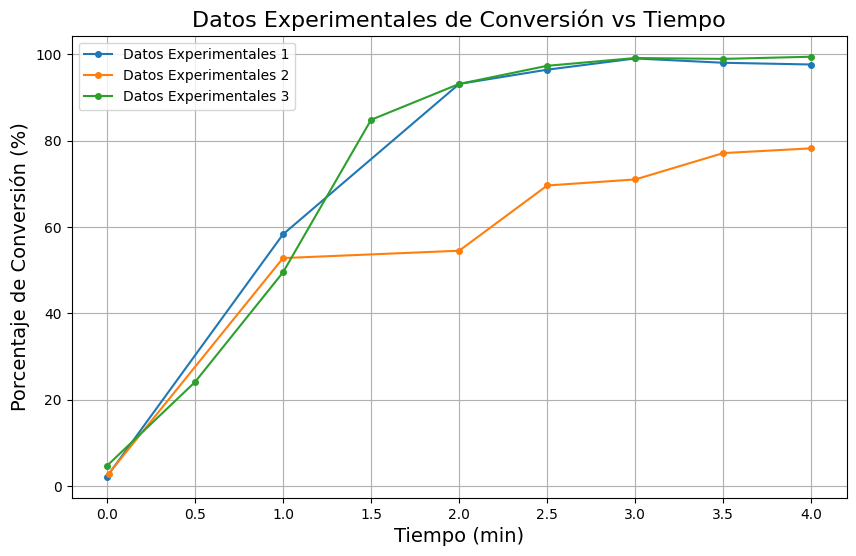

In [91]:
import matplotlib.pyplot as plt

# Lattice y parámetros
L = LatticeSOS(size=30, seed=42)
L.initialize("flat")

params = KMCParams(
    T=298.15,
    K0_plus=1.4,
    K_inc_plus=1.8,
    E_pb_over_kT=0.7,
    phi_over_kT= 1.8,
    delta=1.5,
    V=1.0,
    C_eq=20.0,          # conv_max ~ 95 %
    S_floor=-5.0, S_ceil=8.0
)

kmc = KMC_BKL(L, params, N_bulk0=2000, rng_seed=123, time_scale=200.0, n_seeds=40)


times = np.linspace(0, 10, 25)
snaps = kmc.run(t_end=10, snapshot_times=times)


plt.plot(Experiments[2]['Tiempo'], Experiments[2]['Porcentaje'], label='Datos Experimentales')
plt.plot([t/2.5 for t,_,_ in snaps],
         [conv for _,_,conv in snaps], marker="o")
plt.xlabel("Tiempo simulado (h)")
plt.ylabel("Conversión (%)")
plt.title("BKL con adátomos explícitos (forma en S)")
plt.grid(True)
plt.show()


0.0
0.004079825437204154
0.006783082747119192
0.012063698988556783
0.014152556411276312
0.015001053434114037
0.017035917256511494
0.017459599805786197
0.023293123627866112
0.02337789249723379
0.02474527460008848
0.025838783088352947
0.02766261210607648
0.03156065297363873
0.031638004486036014
0.033290968064574385
0.035534217713903575
0.03839979314472419
0.03928090101981412
0.04204960021751906
0.044077334959019054
0.04453205365337644
0.04602966920714311
0.04694680627445586
0.04786564978569755
0.05069811763437086
0.052654098779242806
0.053278316321005076
0.05376036220404736
0.060908101089148535
0.0611432196929609
0.06150596395592313
0.06323003380556208
0.06385152643550422
0.06498895935138836
0.06507192820413228
0.06813304610827157
0.07174593626221337
0.07463951240492465
0.07602433861294061
0.07638931948446188
0.07727483775602947
0.08096061907532306
0.0826781812295689
0.08280061644054902
0.08392262766728875
0.08685923938993131
0.08903183718526637
0.09158502907984849
0.09159379047188167
0.

/var/folders/0j/wjdr50f52rs1fylv6znxjsbm0000gn/T/ipykernel_27558/841784953.py:142: RuntimeWarning: overflow encountered in exp
  base = self.p.K0_plus * np.exp(S + i * (self.p.delta / max(S, eps)))
/var/folders/0j/wjdr50f52rs1fylv6znxjsbm0000gn/T/ipykernel_27558/841784953.py:200: RuntimeWarning: invalid value encountered in scalar subtract
  r -= Wa


9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.407895888463566
9.40789588

KeyboardInterrupt: 

### ⚡ Estrategias de ajuste

#### Acelerar la cinética (misma meseta, menos tiempo)
- $\uparrow K_{0}^{+}$ (más ads/difusión por unidad de tiempo)  
- $\uparrow K_{\text{inc}}^{+}$ (incorporación más rápida)  
- $\downarrow \phi / k_{B}T \;\; \text{o} \;\; \uparrow E_{\text{pb}}/k_{B}T$ (menos desorción neta)  
- $\uparrow \delta$ (más cooperatividad: sube antes la pendiente media)  
- $\downarrow \text{time\_scale}$ (solo reescala el eje $x$; útil para “encajar” en tu ventana)  

#### Más núcleos iniciales
- $\uparrow n_{\text{seeds}}$ reduce el *lag* inicial y empuja la zona media hacia la izquierda.  

#### Mantener la misma meseta
- No cambies $C_{\text{eq}}$ si quieres el mismo $\%$ final.  
- La meseta viene de:


$$\text{conv}_{\max} \approx 1 - \frac{C_{\text{eq}} \, V}{N_{0}}$$

#### Si además quieres subir/bajar el \% final
- Ajusta solo $C_{\text{eq}}$ con:


$$C_{\text{eq}} = (1 - \text{conv}_{\max}) \, \frac{N_{0}}{V}$$
